In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/patient-churn-datasets/patient_churn_dataset.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report


In [3]:
df = pd.read_csv("/kaggle/input/patient-churn-datasets/patient_churn_dataset.csv")
df.head()


,Patient_ID,Age,Gender,Tenure_Months,Visits_Last_Year,Chronic_Disease,Insurance_Type,Satisfaction_Score,Total_Bill_Amount,Missed_Appointments,Churn
0,1,56,Female,2,3,No,Government,2.5,12252.96,9,1
1,2,69,Male,10,3,Yes,Government,2.6,25862.01,4,0
2,3,46,Female,56,10,No,NaN,2.8,5659.13,4,0
3,4,32,Male,30,4,Yes,Government,4.1,19533.31,5,0
4,5,60,Male,50,19,No,Private,4.6,24639.52,5,0


In [4]:
df.info()
df['Churn'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Patient_ID           500 non-null    int64  
 1   Age                  500 non-null    int64  
 2   Gender               500 non-null    object 
 3   Tenure_Months        500 non-null    int64  
 4   Visits_Last_Year     500 non-null    int64  
 5   Chronic_Disease      500 non-null    object 
 6   Insurance_Type       350 non-null    object 
 7   Satisfaction_Score   500 non-null    float64
 8   Total_Bill_Amount    500 non-null    float64
 9   Missed_Appointments  500 non-null    int64  
 10  Churn                500 non-null    int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 43.1+ KB


Churn
0    0.752
1    0.248
Name: proportion, dtype: float64

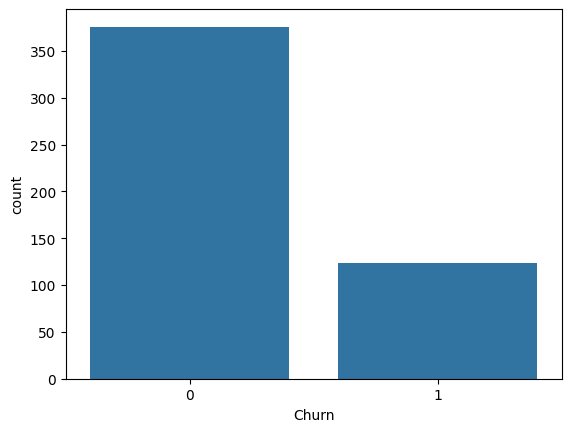

In [5]:
sns.countplot(x='Churn', data=df)
plt.show()


In [6]:
df.isnull().sum()


Patient_ID               0
Age                      0
Gender                   0
Tenure_Months            0
Visits_Last_Year         0
Chronic_Disease          0
Insurance_Type         150
Satisfaction_Score       0
Total_Bill_Amount        0
Missed_Appointments      0
Churn                    0
dtype: int64

In [7]:
df['Insurance_Type'] = df['Insurance_Type'].fillna('Unknown')


In [8]:
df = df.drop('Patient_ID', axis=1)


In [9]:
df = pd.get_dummies(
    df,
    columns=['Gender', 'Chronic_Disease', 'Insurance_Type'],
    drop_first=True
)


In [10]:
X = df.drop('Churn', axis=1)
y = df['Churn']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [12]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [14]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.76      0.49      0.60        75
           1       0.25      0.52      0.34        25

    accuracy                           0.50       100
   macro avg       0.51      0.51      0.47       100
weighted avg       0.63      0.50      0.53       100

ROC AUC: 0.488


In [15]:
feature_importance = pd.Series(
    model.coef_[0],
    index=X.columns
).sort_values(key=abs, ascending=False)

feature_importance



Insurance_Type_Private   -0.146797
Missed_Appointments       0.143970
Satisfaction_Score       -0.101309
Age                      -0.072489
Tenure_Months             0.054132
Total_Bill_Amount        -0.051297
Visits_Last_Year          0.048069
Insurance_Type_Unknown    0.015500
Gender_Male              -0.008512
Chronic_Disease_Yes       0.005516
dtype: float64

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:,1]

print("RF AUC:", roc_auc_score(y_test, rf_prob))


RF AUC: 0.5584
